In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
slim = tf.contrib.slim
from tensorflow.python.framework import constant_op
# from layers import wide_resnet

import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow_probability
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tensorflow_probability.distributions
tfd = tfp.distributions
tfb = tfp.bijectors



In [3]:
import numpy as np
import matplotlib.pyplot as plt
#
import sys
sys.path.append('../code/utils/')
sys.path.append('../code')
import tools
from layers import wide_resnet
#import datalib as dlib
import datatools as dtools
from time import time
#
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_probability
tfd = tensorflow_probability.distributions

# tf.enable_eager_execution()

#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
# path = '/data2/cosmo4d/'
path = '../data/z00//'

ftype = 'L%04d_N%04d_S%04d_%02dstep/'
ftypefpm = 'L%04d_N%04d_S%04d_%02dstep_fpm/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100, 200, 300, 400]
rprob = 0.95

# Training data set

In [4]:
cube_sizes = np.array([ 16, 32, 64, 128])
# cube_sizes = np.array([64])
num_cubes= (500*8/cube_sizes).astype('int')
pad = 0
cube_sizesft = cube_sizes + 2*pad
max_offset = ncp - cube_sizes
ftname = ['cic']
tgname = ['pnn']
nchannels = len(ftname)
rprob = 0.0


In [5]:
   
#############################
##Read data and generate meshes
meshes = {}
cube_features, cube_target = [[] for i in range(len(cube_sizes))], [[] for i in range(len(cube_sizes))]

for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftypefpm%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    mesh['R1'] = tools.fingauss(mesh['cic'], kk, 10, kny)                                                                                                                                                                                                                                

    hmesh = {}
    ##Uncomment for galaxies
#     hpath = path + ftype%(bs, ncf, seed, stepf) + 'galaxies_n05/galcat/'
#     hposd = tools.readbigfile(hpath + 'Position/')
#     massd = tools.readbigfile(hpath + 'Mass/').reshape(-1)*1e10
#     galtype = tools.readbigfile(hpath + 'gal_type/').reshape(-1).astype(bool)
#     hmesh['pnnsat'] = tools.paintnn(hposd[galtype], bs, ncp)
#     hmesh['pnncen'] = tools.paintnn(hposd[~galtype], bs, ncp)
#     hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
#     targetmesh = [hmesh['pnncen'], hmesh['pnnsat']]
    
    hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]    
    hposd = hposall[:num].copy()
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    massall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/Mass/')[1:]    
    massd = massall[:num].copy().reshape(-1)*1e10
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    hmesh['mnn'] = tools.paintnn(hposd, bs, ncp, massd)
    hmesh['lmnn'] = np.log(1+hmesh['mnn'])
#     targetmesh = [hmesh[tgname[0]]
    targetmesh = [hmesh[i].copy() for i in tgname]
                  
    meshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    ntarget = len(targetmesh)

    for i, size in enumerate(cube_sizes):
        print('For size = ', size)
        if size==nc:
            features = [np.stack(ftlistpad, axis=-1)]
            target = [np.stack(targetmesh, axis=-1)]
        else:
            numcubes = int(num_cubes[i]/size*4)
            features, target = dtools.randomvoxels(ftlistpad, targetmesh, numcubes, max_offset[i],
                                            size, cube_sizesft[i], seed=seed, rprob=0)
        cube_features[i] = cube_features[i] + features
        cube_target[i] = cube_target[i] + target

# #
for i in range(cube_sizes.size):
    cube_target[i] = np.stack(cube_target[i],axis=0)
    cube_features[i] = np.stack(cube_features[i],axis=0)
    print(cube_features[i].shape, cube_target[i].shape)

    


All the mesh have been generated for seed = 100
For size =  16
Length of targets =  1
Supplemented by rotation :  0
For size =  32
Length of targets =  1
Supplemented by rotation :  0
For size =  64
Length of targets =  1
Supplemented by rotation :  0
For size =  128
All the mesh have been generated for seed = 200
For size =  16
Length of targets =  1
Supplemented by rotation :  0
For size =  32
Length of targets =  1
Supplemented by rotation :  0
For size =  64
Length of targets =  1
Supplemented by rotation :  0
For size =  128
All the mesh have been generated for seed = 300
For size =  16
Length of targets =  1
Supplemented by rotation :  0
For size =  32
Length of targets =  1
Supplemented by rotation :  0
For size =  64
Length of targets =  1
Supplemented by rotation :  0
For size =  128
All the mesh have been generated for seed = 400
For size =  16
Length of targets =  1
Supplemented by rotation :  0
For size =  32
Length of targets =  1
Supplemented by rotation :  0
For size =  

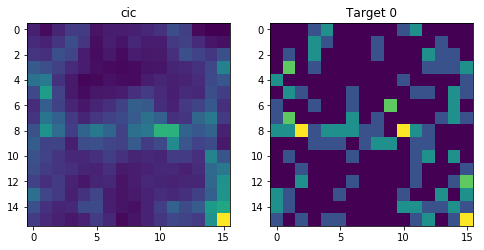

In [6]:
fig, ax = plt.subplots(1, nchannels+ntarget, figsize = (nchannels*4+4, 5))
n = 10
for i in range(nchannels):
    ax[i].imshow(cube_features[0][n][:,:,:,i].sum(axis=0))
    ax[i].set_title(ftname[i])
for j in range(ntarget):
    ax[i+j+1].imshow(cube_target[0][n][:,:,:,j].sum(axis=0))
    ax[i+j+1].set_title('Target %d'%j)
# ax[-1].imshow(cube_target[n][:,:,:,0].sum(axis=0))
# ax[-1].set_title('Target')

In [7]:
cube_target[0].max()

4.0

# Model

In [8]:
  

class Squeeze3d(tfb.Reshape):
    """
    Borrowed from https://github.com/openai/glow/blob/master/tfops.py
    """
    
    def __init__(self,
                 event_shape_in,
                 factor=2,
                 is_constant_jacobian=True,
                 validate_args=False,
                 name=None):

        assert factor >= 1
        name = name or "squeeze"
        self.factor = factor
        event_shape_out = 1*event_shape_in
        event_shape_out[0] //=2
        event_shape_out[1] //=2
        event_shape_out[2] //=2
        event_shape_out[3] *=8
        self.event_shape_out = event_shape_out
        
        super(Squeeze3d, self).__init__(
            event_shape_out=event_shape_out,
            event_shape_in=event_shape_in,
        validate_args=validate_args,
        name=name)
    
    def _forward(self, x):        
        if self.factor == 1:
            return x
        factor = self.factor

        shape = tf.shape(x)
        height = shape[1]
        width = shape[2]
        length = shape[3]
        n_channels = x.get_shape()[4]

#         print(height, width, length, n_channels )
#         assert height % factor == 0 and width % factor == 0 and length % factor == 0
        x = tf.reshape(x, [-1, height//factor, factor,
                           width//factor, factor, length//factor, factor, n_channels])
        x = tf.transpose(x, [0, 1, 3, 5, 7, 2, 4, 6])
        x = tf.reshape(x, [-1, height//factor, width//factor, 
                               length//factor, n_channels*factor**3])
        return x
    
    def _inverse(self, x):        
        if self.factor == 1:
            return x
        factor = self.factor

        shape = tf.shape(x)
        height = shape[1]
        width = shape[2]
        length = shape[3]
        n_channels = int(x.get_shape()[4])
        
#         print(height, width, length, n_channels )
        assert n_channels >= 8 and n_channels % 8 == 0
        x = tf.reshape(
            x, [-1, height, width, length, int(n_channels/factor**3), factor, factor, factor])
        x = tf.transpose(x, [0, 1, 5, 2, 6, 3, 7, 4])
        x = tf.reshape(x, (-1, height*factor,
                           width*factor, height*factor, int(n_channels/factor**3)))
        return x
    

    


In [9]:
# n = 4
# tmp = tf.constant(np.arange(n**3).reshape(1, n, n, n, 1))
# sq = Squeeze3d([n, n, n, 1])
# tmp2 = sq.forward(tmp)
# tmp2.shape
# tmp3 = sq.inverse(tmp2)
# tmp3 - tmp

In [10]:
import warnings

NO_OPS = 'NO_OPS'

def _l2normalize(v, eps=1e-12):
  return v / (tf.reduce_sum(v ** 2) ** 0.5 + eps)


def spectral_normed_weight(W, u=None, num_iters=1, update_collection=None, with_sigma=False):
  # Usually num_iters = 1 will be enough
  W_shape = W.shape.as_list()
  W_reshaped = tf.reshape(W, [-1, W_shape[-1]])
  if u is None:
    u = tf.get_variable("u", [1, W_shape[-1]], initializer=tf.truncated_normal_initializer(), trainable=False)
  def power_iteration(i, u_i, v_i):
    v_ip1 = _l2normalize(tf.matmul(u_i, tf.transpose(W_reshaped)))
    u_ip1 = _l2normalize(tf.matmul(v_ip1, W_reshaped))
    return i + 1, u_ip1, v_ip1
  _, u_final, v_final = tf.while_loop(
    cond=lambda i, _1, _2: i < num_iters,
    body=power_iteration,
    loop_vars=(tf.constant(0, dtype=tf.int32),
               u, tf.zeros(dtype=tf.float32, shape=[1, W_reshaped.shape.as_list()[0]]))
  )
  if update_collection is None:
    warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
                  '. Please consider using a update collection instead.')
    sigma = tf.matmul(tf.matmul(v_final, W_reshaped), tf.transpose(u_final))[0, 0]
    # sigma = tf.reduce_sum(tf.matmul(u_final, tf.transpose(W_reshaped)) * v_final)
    W_bar = W_reshaped / sigma
    with tf.control_dependencies([u.assign(u_final)]):
      W_bar = tf.reshape(W_bar, W_shape)
  else:
    sigma = tf.matmul(tf.matmul(v_final, W_reshaped), tf.transpose(u_final))[0, 0]
    # sigma = tf.reduce_sum(tf.matmul(u_final, tf.transpose(W_reshaped)) * v_final)
    W_bar = W_reshaped / sigma
    W_bar = tf.reshape(W_bar, W_shape)
    # Put NO_OPS to not update any collection. This is useful for the second call of discriminator if the update_op
    # has already been collected on the first call.
    if update_collection != NO_OPS:
      tf.add_to_collection(update_collection, u.assign(u_final))
  if with_sigma:
    return W_bar, sigma
  else:
    return W_bar

In [11]:
def scope_has_variables(scope):
  return len(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope.name)) > 0

def myconv3d(input_, output_dim,
           k_h=4, k_w=4, k_z=4, d_h=2, d_w=2, d_z=2, stddev=None,
           name="conv3d", spectral_normed=True, update_collection=None, with_w=False, padding="SAME", reuse=tf.AUTO_REUSE):
  # Glorot intialization
  # For RELU nonlinearity, it's sqrt(2./(n_in)) instead
  fan_in = k_h * k_w * k_z * input_.get_shape().as_list()[-1]
  fan_out = k_h * k_w * k_z * output_dim
  if stddev is None:
    stddev = np.sqrt(2. / (fan_in))

  with tf.variable_scope(name) as scope:
    if scope_has_variables(scope):
      scope.reuse_variables()
    w = tf.get_variable("w", [k_h, k_w, k_z, input_.get_shape()[-1], output_dim],
                        initializer=tf.truncated_normal_initializer(stddev=stddev))
    if spectral_normed:
      conv = tf.nn.conv3d(input_, spectral_normed_weight(w, update_collection=update_collection),
                          strides=[1, d_h, d_w, d_z, 1], padding=padding)
    else:
      conv = tf.nn.conv3d(input_, w, strides=[1, d_h, d_w, d_z, 1], padding=padding)

    biases = tf.get_variable("b", [output_dim], initializer=tf.constant_initializer(0.0))
    conv = tf.nn.bias_add(conv, biases)
    if with_w:
      return conv, w, biases
    else:
      return conv

In [12]:

h = 0.5


class iRevNetsimple(tfb.Bijector):

    def __init__(self,
       h=1.0,
       is_constant_jacobian=True,
       validate_args=False,
       name=None, kernel_size=3):
        self.h = h
        self.kernel_size = kernel_size
        name = name or "revnet"
        super(iRevNetsimple, self).__init__(
        forward_min_event_ndims=3,
        is_constant_jacobian=is_constant_jacobian,
        validate_args=validate_args,
        name=name)
        
    def _forward(self, x):
        # Split the input in half
        x1, x2 = tf.split(x, num_or_size_splits=2, axis=-1)
        fx2 = myconv3d(x2, x2.shape[-1], 
                          self.kernel_size, self.kernel_size,  self.kernel_size, 
                          1, 1, 1, #training=True, 
                          name=self.name+'/bottle', 
                               reuse=tf.AUTO_REUSE)
        fx2 = tf.nn.leaky_relu(fx2)
        fx2 = myconv3d(x2, x2.shape[-1], 
                          self.kernel_size, self.kernel_size,  self.kernel_size, 
                          1, 1, 1, #training=True, 
                          name=self.name+'/bottle', 
                               reuse=tf.AUTO_REUSE)
        fx2 = tf.nn.leaky_relu(fx2)

        y1 = x1 + self.h*fx2
        return tf.concat([x2, y1], axis=-1)
    
    def _inverse(self, x, kernel_size=3):
        x2, y1 = tf.split(x, num_or_size_splits=2, axis=-1)
        Fx2 =  myconv3d(x2, x2.shape[-1], 
                          self.kernel_size, self.kernel_size,  self.kernel_size, 
                          1, 1, 1, #training=True, 
                          name=self.name+'/bottle', 
                               reuse=tf.AUTO_REUSE)
        Fx2 = tf.nn.leaky_relu(Fx2)
        Fx2 =  myconv3d(x2, x2.shape[-1], 
                          self.kernel_size, self.kernel_size,  self.kernel_size, 
                          1, 1, 1, #training=True, 
                          name=self.name+'/bottle', 
                               reuse=tf.AUTO_REUSE)
        Fx2 = tf.nn.leaky_relu(Fx2)
        Fx2 = - self.h*Fx2

        x1 = Fx2 + y1
        return tf.concat([x1, x2], axis=-1)

    def _inverse_log_det_jacobian(self, y):
        return constant_op.constant(0., x.dtype.base_dtype)

    def _forward_log_det_jacobian(self, x):     
        return constant_op.constant(0., x.dtype.base_dtype)

In [ ]:

tf.reset_default_graph()


cube_size = cube_features[0].shape[0]
# feature_layer = tf.placeholder(tf.float32, shape=[None, cube_sizeft,  cube_sizeft,  cube_sizeft,  nchannels], name='input')
feature_layer = tf.placeholder(tf.float32, shape=[None, None,  None,  None,  nchannels], name='input')
chain = tfb.Chain([tfb.Invert(Squeeze3d(event_shape_in=[cube_size, cube_size, cube_size, nchannels])),
           iRevNetsimple(name='layer1',h=h),
           iRevNetsimple(name='layer1b',h=h),
           tfb.Permute(arange(8)[::-1],axis=-1),
           iRevNetsimple(name='layer3',h=h),
           iRevNetsimple(name='layer3b',h=h),
           tfb.Invert(Squeeze3d(event_shape_in=[cube_size//2,cube_size//2,cube_size//2,nchannels*8])), 
           iRevNetsimple(name='layer11',h=h),
           iRevNetsimple(name='layer11b',h=h),
           Squeeze3d(event_shape_in=[cube_size//2,cube_size//2,cube_size//2,nchannels*8]), 
           iRevNetsimple(name='layer13',h=h),
           iRevNetsimple(name='layer13b',h=h),
           tfb.Permute(arange(8)[::-1],axis=-1),
           iRevNetsimple(name='layer15',h=h),
           iRevNetsimple(name='layer15b',h=h),
           Squeeze3d(event_shape_in=[cube_size, cube_size, cube_size, nchannels])])
# chain = tfb.Chain([Squeeze3d(event_shape_in=[cube_size, cube_size, cube_size, nchannels])])

bijection = chain

net = bijection.forward(feature_layer)
net2 = bijection.inverse(net+0)


with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
    pred = sess.run([net, net2], {feature_layer:cube_features[0][:1]})
#     pred = sess.run(net, {feature_layer:cube_features[1][:2]})
    
# diff = (abs(pred[1] - cube_features[0][:2])/cube_features[0][:2])
diff = (abs(pred[1] - cube_features[0][:1]))
diff[~np.isnan(diff)].max()

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
/home/chmodi/.local/lib/python3.6/si

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.


In [ ]:
# pred0 = np.squeeze(pred[0])

# plt.figure(figsize=(8, 4))
# for i in range(8):
#     ax = plt.subplot(2,4,i+1, )
#     ax.imshow(pred0[...,i].sum(axis=0))
# plt.show()
# plt.imshow(cube_features[0][0,...,0].sum(axis=0))
# plt.show()


In [ ]:


# def _mdn_model_fn(features, labels, n_y, n_mixture, cube_size, dropout, optimizer, mode):
def _mdn_model_fn(features, labels, n_y, nchannels, dropout, optimizer, mode):

    # Check for training mode
    is_training = mode == tf.estimator.ModeKeys.TRAIN
        
    def _module_fn():
        """
        Function building the module
        """
    
        feature_layer = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
        obs_layer = tf.placeholder(tf.float32, shape=[None, None, None, None, n_y], name='observations')
        

        # Builds the neural network
        # ! ny and nchannel need to be the same

        cube_size = tf.shape(feature_layer)[1]
#         print(cube_size)
        chain = tfb.Chain([tfb.Invert(Squeeze3d(event_shape_in=[cube_size, cube_size, cube_size, nchannels])),
                   iRevNetsimple(name='layer1',h=h),
                   iRevNetsimple(name='layer1b',h=h),
                   iRevNetsimple(name='layer2',h=h),
                   iRevNetsimple(name='layer2b',h=h),
                   tfb.Permute(arange(8)[::-1],axis=-1),
                   iRevNetsimple(name='layer3',h=h),
                   iRevNetsimple(name='layer3b',h=h),
                   iRevNetsimple(name='layer4',h=h),
                   iRevNetsimple(name='layer4b',h=h),
                   tfb.Invert(Squeeze3d(event_shape_in=[cube_size//2,cube_size//2,cube_size//2,nchannels*8])), 
                   iRevNetsimple(name='layer5',h=h),
                   iRevNetsimple(name='layer5b',h=h),
                   iRevNetsimple(name='layer6',h=h),
                   iRevNetsimple(name='layer6b',h=h),
                   tfb.Permute(arange(64)[::-1],axis=-1),
                   iRevNetsimple(name='layer7',h=h),
                   iRevNetsimple(name='layer7b',h=h),
                   iRevNetsimple(name='layer8',h=h),
                   iRevNetsimple(name='layer8b',h=h),
                   tfb.Invert(Squeeze3d(event_shape_in=[cube_size//4,cube_size//4,cube_size//4,nchannels*64])), 
                   iRevNetsimple(name='layer9',h=h, kernel_size=1),
                   iRevNetsimple(name='layer9b',h=h, kernel_size=1),
                   iRevNetsimple(name='layer10',h=h, kernel_size=1),
                   iRevNetsimple(name='layer10b',h=h, kernel_size=1),
                   tfb.Permute(arange(64*8)[::-1],axis=-1),
                   iRevNetsimple(name='layer11',h=h, kernel_size=1),
                   iRevNetsimple(name='layer11b',h=h, kernel_size=1),
                   iRevNetsimple(name='layer12',h=h, kernel_size=1),
                   iRevNetsimple(name='layer12b',h=h, kernel_size=1),
                   Squeeze3d(event_shape_in=[cube_size//4,cube_size//4,cube_size//4,nchannels*64]), 
                   iRevNetsimple(name='layer13',h=h),
                   iRevNetsimple(name='layer13b',h=h),
                   iRevNetsimple(name='layer14',h=h),
                   iRevNetsimple(name='layer14b',h=h),
                   tfb.Permute(arange(64)[::-1],axis=-1),
                   iRevNetsimple(name='layer15',h=h),
                   iRevNetsimple(name='layer15b',h=h),
                   iRevNetsimple(name='layer16',h=h),
                   iRevNetsimple(name='layer16b',h=h),
                   Squeeze3d(event_shape_in=[cube_size//2,cube_size//2,cube_size//2,nchannels*8]), 
                   iRevNetsimple(name='layer17',h=h),
                   iRevNetsimple(name='layer17b',h=h),
                   iRevNetsimple(name='layer18',h=h),
                   iRevNetsimple(name='layer18b',h=h),
                   tfb.Permute(arange(8)[::-1],axis=-1),
                   iRevNetsimple(name='layer19',h=h),
                   iRevNetsimple(name='layer19b',h=h),
                   iRevNetsimple(name='layer20',h=h),
                   iRevNetsimple(name='layer20b',h=h),
                   Squeeze3d(event_shape_in=[cube_size, cube_size, cube_size, nchannels])])

        bijection = chain
        
        net = bijection.forward(feature_layer)
        lbda = tf.nn.softplus(net, name='lambda') + 1e-5

        dist = tfd.Poisson(lbda)
        
        sample = tf.squeeze(dist.sample())
        loglik = dist.log_prob(obs_layer)
        
#         l2 = tf.reduce_mean(tf.square(tf.subtract(obs_layer, net)))
        diff = (tf.subtract(obs_layer, net))
    
        hub.add_signature(inputs={'features':feature_layer, 'labels':obs_layer}, 
                          outputs={'sample':sample, 'loglikelihood':loglik, 'lambda':lbda, 
                                   'difference':diff})
    
    # Create model and register module if necessary
    spec = hub.create_module_spec(_module_fn)
    module = hub.Module(spec, trainable=True)
    if isinstance(features,dict):
        predictions = module(features, as_dict=True)
    else:
        predictions = module({'features':features, 'labels':labels}, as_dict=True)
    
    if mode == tf.estimator.ModeKeys.PREDICT:    
        hub.register_module_for_export(module, "likelihood")
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # Compute and register loss function
    loglik = -predictions['loglikelihood']
#     diff = predictions['difference']
#     loglik = tf.square(diff)
    
    neg_log_likelihood = tf.reduce_sum(loglik, axis=-1)
    neg_log_likelihood = tf.reduce_mean(neg_log_likelihood)
    tf.losses.add_loss(neg_log_likelihood)
    total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

    train_op = None
    eval_metric_ops = None

    # Define optimizer
    if mode == tf.estimator.ModeKeys.TRAIN:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer(learning_rate=0.001).minimize(loss=total_loss,
                                        global_step=tf.train.get_global_step())
        tf.summary.scalar('loss', neg_log_likelihood)
    elif mode == tf.estimator.ModeKeys.EVAL:
        
        eval_metric_ops = { "log_p": neg_log_likelihood}

    return tf.estimator.EstimatorSpec(mode=mode,
                                      predictions=predictions,
                                      loss=total_loss,
                                      train_op=train_op,
                                      eval_metric_ops=eval_metric_ops)

class MDNEstimator(tf.estimator.Estimator):
    """An estimator for distribution estimation using Mixture Density Networks.
    """

    def __init__(self,
                 n_y,
                 nchannels,
#                  cube_size,
                 optimizer=tf.train.AdamOptimizer,
                 dropout=None,
                 model_dir=None,
                 config=None):
        """Initializes a `MDNEstimator` instance.
        """

        def _model_fn(features, labels, mode):
            return _mdn_model_fn(features, labels, 
                 n_y, nchannels, #cube_size, 
                        dropout, optimizer, mode)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [ ]:
batch_size = 32

def mapping_function(inds):
    def extract_batch(inds):

        isize = np.random.choice(len(cube_sizes), 1, replace=True)[0]
        batch = int(batch_size*8/cube_sizes[isize])
        if cube_sizes[isize]==nc : batch = 1
        inds = inds[:batch]
        trainingsize = cube_features[isize].shape[0]
        inds[inds >= trainingsize] =  (inds[inds >= trainingsize])%trainingsize

        features = cube_features[isize][inds].astype('float32')
        targets = cube_target[isize][inds].astype('float32')

        for i in range(batch):
            nrotations=0
            while (np.random.random() < rprob) & (nrotations < 3):
                nrot, ax0, ax1 = np.random.randint(0, 3), *np.random.permutation((0, 1, 2))[:2]
                features[i] = np.rot90(features[i], nrot, (ax0, ax1))
                targets[i] = np.rot90(targets[i], nrot, (ax0, ax1))
                nrotations +=1
#             print(batch, isize, i, nrotations, targets[i].shape, targets.shape)                                                                                                                   
# #         print(inds)                                                                                                                                                         
        return features, targets

    ft, tg = tf.py_func(extract_batch, [inds],
                        [tf.float32, tf.float32])
#     sft = cube_features[isize].shape                                                                                                                                          
#     stg = cube_target[isize].shape                                                                                                                                            
#     ft.set_shape((None,)+sft[1:])                                                                                                                                             
#     tg.set_shape((None,)+stg[1:])                                                                                                                                             
    return ft, tg


def training_input_fn():
    """Serving input fn for training data"""

    dataset = tf.data.Dataset.range(len(np.array(cube_features)[0]))
    dataset = dataset.repeat().shuffle(1000).batch(batch_size)
    dataset = dataset.map(mapping_function)
    dataset = dataset.prefetch(16)
    return dataset


def testing_input_fn():
    """Serving input fn for testing data"""
    dataset = tf.data.Dataset.range(len(cube_features))
    dataset = dataset.batch(16)
    dataset = dataset.map(mapping_function)
    return dataset

In [ ]:
savepath = './models/n10/rev-SN-act2/'

run_config = tf.estimator.RunConfig(save_checkpoints_steps = 1000)

model =  MDNEstimator(n_y=ntarget, nchannels=nchannels, dropout=0.95,
                      model_dir=savepath + '/model/', config = run_config)
#                       model_dir='./tmp/galmodel/model0', config = run_config)

In [ ]:
# Trying to export
features = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
labels = tf.placeholder(tf.float32, shape=[None, None, None, None, ntarget], name='observations')
    
exporter = hub.LatestModuleExporter("tf_hub",
        tf.estimator.export.build_raw_serving_input_receiver_fn({'features':features, 'labels':labels},
                                                                   default_batch_size=None))

# Train

In [ ]:
%%bash 
# ls ./models/n10/rev-SN-act/
# rm -r ./models/n10/rev-SN-act
# tf.summary.FileWriterCache.clear()

In [ ]:
import warnings
warnings.filterwarnings('ignore')
model.train(training_input_fn, max_steps=10000)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
modulepath = exporter.export(model, savepath + '/module/', model.latest_checkpoint())
modulepath = modulepath.decode("utf-8")
modulepath

## Testing

In [ ]:
tf.reset_default_graph()
# modulepath = './models/n10/rev-SN2//module/1548795689/'
# modulepath = '/home/chmodi/Projects/galmodel/notebooks/models/n10/rev-SN/module/1548733709/'
module = hub.Module(modulepath + '/likelihood/')

# module_inf = hub.Module(modulepath + '/inference/')
# module = hub.Module('../code/models/galmodel/pad2/module/1546484684/likelihood/')
xx = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, None, None, None, ntarget], name='labels')
samples = module(dict(features=xx, labels=yy), as_dict=True)['sample']
loglik = module(dict(features=xx, labels=yy), as_dict=True)['difference']
poisson = module(dict(features=xx, labels=yy), as_dict=True)['lambda']

with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
        
    features = cube_features[0][5:8].astype('float32')
    targets = cube_target[0][5:8].astype('float32')
    xxm = features
    yym = targets
    print(xxm.shape, yym.shape)
    preds = sess.run(samples, feed_dict={xx:xxm, yy:yym})
    pois = sess.run(poisson, feed_dict={xx:xxm, yy:yym})


In [ ]:
preds.shape

In [ ]:
im = imshow(preds[0,:,:,:].sum(axis=-1))
plt.colorbar(im)

In [ ]:
i = imshow(targets[0,:,:,:, 0].sum(axis=-1))
plt.colorbar(im)

In [ ]:
i = imshow(pois[0,:,:,:, 0].sum(axis=-1))
plt.colorbar(im)

In [ ]:
i = imshow((pois[0,:,:,:, 0]-targets[0,:,:,:, 0]).sum(axis=-1))
plt.colorbar(im)

In [ ]:
i = imshow(features[0,:,:,:, 0].sum(axis=-1))
plt.colorbar(im)

In [ ]:
tf.reset_default_graph()

module = hub.Module(modulepath + '/likelihood/')

# module = hub.Module('../code/models/galmodel/pad2/module/1546484684/likelihood/')

xx = tf.placeholder(tf.float32, shape=[None, None, None, None, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, None, None, None, ntarget], name='labels')
samples = module(dict(features=xx, labels=yy), as_dict=True)['sample']
loglik = module(dict(features=xx, labels=yy), as_dict=True)['difference']
poisson = module(dict(features=xx, labels=yy), as_dict=True)['lambda']

preds = {}
pois = {}
llik = {}
with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())

    for seed in seeds:
        xxm = np.pad(meshes[seed][0]['cic'], pad, 'wrap')
        xxm = np.expand_dims(np.expand_dims(xxm,  -1), 0)

        yym = np.stack([meshes[seed][1]['pnn']], axis=-1)
        yym = np.expand_dims(yym, 0)
        preds[seed] = sess.run(samples, feed_dict={xx:xxm, yy:yym})
        meshes[seed][0]['predict'] = np.squeeze(preds[seed][:, :, :])
        pois[seed] = sess.run(poisson, feed_dict={xx:xxm, yy:yym})
        meshes[seed][0]['lambda'] = np.squeeze(pois[seed][:, :, :])
#         llik[seed] = sess.run(loglik, feed_dict={xx:xxm, yy:yym})
#         meshes[seed][0]['loglik'] = np.squeeze(llik[seed][:, :, :])


In [ ]:
meshes[seed][0]['lambda'];

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """


KeyError: 'predict'

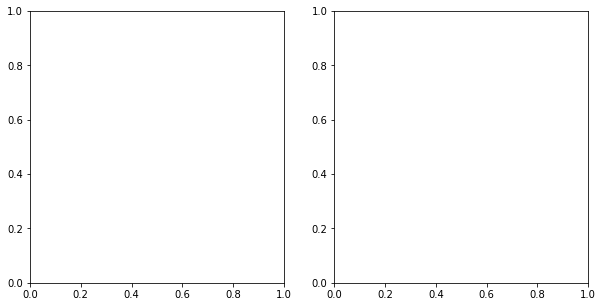

In [14]:
##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
for seed in seeds:
    key = ''
    predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
#     predict, hpmeshd = meshes[seed][0]['lambda%s'%key] , meshes[seed][1]['pnn%s'%key], 
#     predict, hpmeshd = meshes[seed][0]['lambda%s'%key] , meshes[seed][0]['cic%s'%key], 
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)    
##
    ax[0].semilogx(k[1:], pkpred[1:]/pkhd[1:], label=seed)
    ax[1].semilogx(k[1:], pkhx[1:]/(pkpred[1:]*pkhd[1:])**0.5)
    
for axis in ax.flatten():
    axis.legend(fontsize=14)
    axis.set_yticks(np.arange(0, 1.1, 0.1))
    axis.grid(which='both')
    axis.set_ylim(0.,1.1)
ax[0].set_ylabel('Transfer function', fontsize=14)
ax[1].set_ylabel('Cross correlation', fontsize=14)
plt.show()

# ##################################################
fig, ax = plt.subplots(1, 2, figsize=(10,5))

key = ''
predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn%s'%key], 
# predict, hpmeshd = meshes[seed][0]['lambda%s'%key] , meshes[seed][1]['pnn%s'%key], 
vmin, vmax = 0, (hpmeshd[:, :, :].sum(axis=0)).max()
vmin, vmax =  None, None
im = ax[0].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[1])
ax[0].set_ylabel('Prediction', fontsize=15)
ax[1].set_ylabel('Truth', fontsize=15)
plt.show()


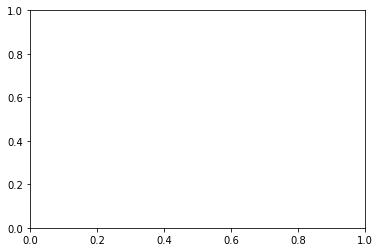

In [162]:
# predict, hpmeshd = meshes[seed][0]['lambda%s'%key] , meshes[seed][0]['cic'], 
predict, hpmeshd = meshes[seed][0]['predict%s'%key] , meshes[seed][1]['pnn'], 
vmin, vmax = 0, (hpmeshd[:, :, :].sum(axis=0)).max()
vmin, vmax =  None, None
im = ax[0].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[1])
ax[0].set_ylabel('Prediction', fontsize=15)
ax[1].set_ylabel('Truth', fontsize=15)
plt.show()

# vmin, vmax = 0, (hpmeshd[:, :, :].sum(axis=0)).max()
# vmin, vmax =  None, None
# im = ax[0].imshow(predict[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
# plt.colorbar(im, ax=ax[0])
# im = ax[1].imshow(hpmeshd[:, :, :].sum(axis=0), vmin=vmin, vmax=vmax)
# plt.colorbar(im, ax=ax[1])
# ax[0].set_ylabel('Prediction', fontsize=15)
# ax[1].set_ylabel('Truth', fontsize=15)
# plt.show()
